In [47]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import shutil
from copy import deepcopy
from sklearn.model_selection import KFold
from torch.utils.data import Subset,Dataset,DataLoader
import pandas as pd
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score



In [48]:
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
os.listdir(path)

['Dataset']

In [49]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [50]:
data_folder = os.path.join(path,"Dataset")
train_path = os.path.join(data_folder,"Train")
test_path = os.path.join(data_folder,"Test")
validation_path = os.path.join(data_folder,"Validation")
tuning_path = os.path.join(data_folder,"Tuning")
os.makedirs(os.path.join(tuning_path,"Real"),exist_ok=True)
os.makedirs(os.path.join(tuning_path,"Fake"),exist_ok=True)

In [51]:
for folder in os.listdir(train_path):
  i=0
  for file in os.listdir(os.path.join(train_path,folder)):
    shutil.copy(os.path.join(train_path,folder,file),os.path.join(tuning_path,folder,file))
    i+=1
    if i ==50:
      break

/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Train/Real/real_33163.jpg


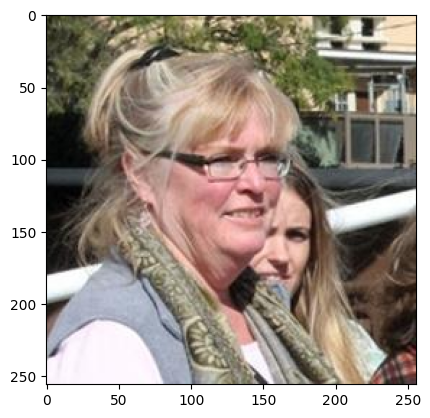

/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Train/Real/real_54777.jpg


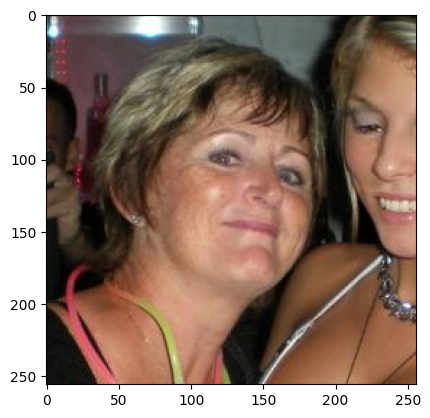

/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Train/Fake/fake_11143.jpg


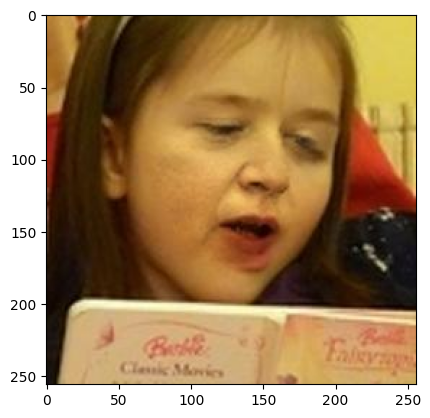

/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Train/Fake/fake_50887.jpg


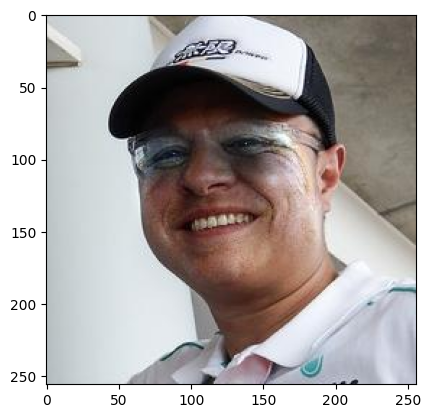

In [52]:
sample = os.listdir(os.path.join(train_path,"Real"))
for i in range(2):
    image_path = os.path.join(train_path,"Real",sample[i])
    print(image_path)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.show()
sample = os.listdir(os.path.join(train_path,"Fake"))
for i in range(2):
    image_path = os.path.join(train_path,"Fake",sample[i])
    print(image_path)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.show()

In [53]:
train_generator = ImageDataGenerator(
    rescale = 1/255

)
test_generator = ImageDataGenerator(
    rescale = 1/255
)
validation_generator = ImageDataGenerator(
    rescale = 1/255
)
tuning_generator = ImageDataGenerator(
    rescale = 1/255
)

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,6,(5,5))
        self.averagePooling1 = nn.AvgPool2d(2)

        self.conv2 = nn.Conv2d(6,16,(5,5))
        self.averagePooling2 = nn.AvgPool2d(2)

        self.linear1 = nn.Linear(55696,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,1)
        self.initialize_weights()

    def initialize_weights(self):
          for layer in self.modules():
            if isinstance(layer,nn.Linear) or isinstance(layer,nn.Conv2d):
                nn.init.xavier_normal_(layer.weight)

    def forward(self,x):
         x = F.relu(self.conv1(x))
         x = self.averagePooling1(x)

         x = F.relu(self.conv2(x))
         x = self.averagePooling2(x)

         x = x.reshape(x.size(0), -1)

         x = F.relu(self.linear1(x))
         x = F.relu(self.linear2(x))
         x = F.sigmoid(self.linear3(x))

         return x

In [55]:
def train(data,epoch ,model,optimizer,loss_fun):
    total_loss = []
    model.train()
    for ep in range(epoch):
        for i, (x, target) in enumerate(data):
            if i >= len(data):
                break
            optimizer.zero_grad()

            target = torch.tensor(target).to(device)
            target = target.float()
            target = target[:,0].unsqueeze(-1)
            x = torch.tensor(x).to(device)
            x = x.permute(0, 3, 1, 2)
            x = x.float()

            target = target.to(device)
            x= x.to(device)

            outputs = model(x)

            loss = loss_fun(outputs,target)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            print(f"\rEpoch {ep+1}, loss: {loss.item():.8f},",end="")

    return total_loss

In [56]:
tuning_data = tuning_generator.flow_from_directory(
    tuning_path,
    target_size = (250,250),
    batch_size=20
)

Found 100 images belonging to 2 classes.


In [57]:
class GreyWolfOA:
    def __init__(self, n=5,i=100):
        self.population_size = n
        self.iterations = i
    def fittness(self, population,is_fittness_calculated,previous_fittness_values):
        population = np.array(population)
        values = []
        i=0
        print("fittness: ")
        for index,sample in enumerate(population):
          if is_fittness_calculated[index]:
            values.append(previous_fittness_values[index])
            continue
          elif population[index]<0:
            values.append(10000000)
            continue
          else:
            print("lr: ",population[index])
            model = CNN().to(self.device)
            optimizer = torch.optim.Adam(model.parameters(),lr= sample)
            loss_fun = nn.BCELoss()
            history = train(self.data,10,model,optimizer,loss_fun)
            # print(np.array(history["loss"][-5:]).mean())
            values.append(np.array(history[-5:]).mean())
            i+=1
            is_fittness_calculated[index] = True
        return values , is_fittness_calculated

    def calc_singleX(self,a,sample_i, wolf):#wolf = (alpha,beta,gamma)
        random1,random2 = np.random.uniform(0.00001,0.001),np.random.uniform(0.00001,0.001)
        A = (2*a* random1) - a
        B = 2* random2
        C = np.abs(B* wolf - sample_i)
        x = wolf - A*C
        # print("random 1 ",random1)
        # print("random 2 ",random2)
        # print("a ",a)
        # print("A ",A)
        # print("b ",B)
        # print("c ",C)
        # print("x ",x)
        # print("wolf ",wolf)
        # print('==========================')

        return x

    def fit(self,data,device):
        self.data = data
        self.device = device

        population = np.random.uniform(0.00001,0.001,size=self.population_size)
        is_fittness_calculated= [False for _ in range(self.population_size)]
        history = []
        previous_fittness_values = []
        for i in range(self.iterations):

            fitness_values,is_fittness_calculated = self.fittness(population,is_fittness_calculated,previous_fittness_values)
            indecies = np.argsort(fitness_values)

            alpha = population[indecies[0]]
            beta = population[indecies[1]]
            gamma = population[indecies[2]]
            a = 2 *(1-(i /self.iterations))**30

            for sample in range(self.population_size):
                x1 = self.calc_singleX(a,sample,alpha)
                x2 = self.calc_singleX(a,sample,beta)
                x3 = self.calc_singleX(a,sample,gamma)


                new_x = (x1+x2+x3)/3
                new_fittness,_= self.fittness([new_x],[False],[0])
                if fitness_values[sample] > new_fittness[0]:
                    population[sample] = new_x
                    fitness_values[sample]= new_fittness[0]
                    is_fittness_calculated[sample]=True

            previous_fittness_values= deepcopy(fitness_values)

            indecies = np.argsort(fitness_values)
            history.append([population[indecies[0]],fitness_values[indecies[0]]])
            print("-----------alpha is: ",population[indecies[0]],"loss: ",fitness_values[indecies[0]])
            print('-----------------------------------------------------------')
            print(f'Iteration {i+1}population: {population}')
        return population[indecies[0]],history

In [58]:
greywolf = GreyWolfOA(5,8)
alpha , history = greywolf.fit(tuning_data,device)

fittness: 
lr:  0.0004038774574778763
Epoch 10, loss: 0.11234237,lr:  0.0007866425856927213
Epoch 10, loss: 0.06803048,lr:  4.7389921718705995e-05
Epoch 10, loss: 0.40818238,lr:  0.0007105003179380408
Epoch 10, loss: 0.10609541,lr:  0.00014311587769482866
Epoch 10, loss: 0.45475039,fittness: 
lr:  0.0006341814524482429
Epoch 10, loss: 0.33564273,fittness: 
lr:  1.9992249520034469
Epoch 10, loss: 65.00000000,fittness: 
lr:  3.9965917287862993
Epoch 10, loss: 40.00000000,fittness: 
lr:  5.997305643970715
Epoch 10, loss: 55.00000000,fittness: 
lr:  7.995385490365745
Epoch 10, loss: 50.00000000,-----------alpha is:  0.0007866425856927213 loss:  0.0419277872890234
-----------------------------------------------------------
Iteration 1population: [4.03877457e-04 7.86642586e-04 4.73899217e-05 7.10500318e-04
 1.43115878e-04]
fittness: 
fittness: 
lr:  0.0006337100900226768
Epoch 10, loss: 0.12403641,fittness: 
lr:  0.037007457466085664
Epoch 10, loss: 55.00000000,fittness: 
lr:  0.073388526396

In [93]:
def evaluate_model(model, loss_fun,data_loader):
  model.eval()
  data_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
      for i,(x, y) in enumerate(data_loader):
          if i >= len(data_loader):
                  break
          x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
          y = y[:,0].unsqueeze(-1)
          x = x.permute(0, 3, 1, 2)

          outputs = model(x)
          loss = loss_fun(outputs, y)
          data_loss += loss.item()
          for t in range(len(outputs)):
            if outputs[t] >= 0.5 and y[t]==1:
              correct+= 1
              total+=1
            elif outputs[t] < 0.5 and y[t]==0:
              correct += 1
              total+=1
            else:
              total+=1
          predicted = np.array(outputs.cpu().numpy()>=0.5).astype(int)
          correct += (predicted == y.cpu().numpy()).sum().item()
          total += y.size(0)
          if  i==2:
            break

  data_loss /= len(data_loader)
  val_accuracy = correct / total
  return data_loss, val_accuracy

def train_cross_validation(data,epoch):

    k_folds = 3
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_results=[]
    models_details=[]


    for fold_number,(train_idx,val_idx) in enumerate(kf.split(data)):

      history = {
          "train_loss":[],
          "val_loss":[],
          "train_accuracy":[],
          "val_accuracy":[]
      }

      train_subset = np.array(data)[train_idx]
      val_subset = np.array(data)[val_idx]

      train_datafram = pd.DataFrame(train_subset,columns=["path","label"])
      val_datafram = pd.DataFrame(val_subset,columns=["path","label"])

      train_loader = train_generator.flow_from_dataframe(
             train_datafram ,
              x_col="path",
              y_col="label",
              target_size = (250,250),
              batch_size=32
              )

      val_loader = train_generator.flow_from_dataframe(
              val_datafram ,
              x_col="path",
              y_col="label",
              target_size = (250,250),
              batch_size=32
                 )

      model = CNN().to(device)
      optimizer = torch.optim.Adam(model.parameters(),lr= 0.001097470225046833)
      loss_fun = nn.BCELoss()

      print(f"fold {fold_number+1}/3: ----------------------------- ")
      total_loss = []
      model.train()
      for ep in range(epoch):
          for i, (x, target) in enumerate(train_loader):
              if i >= len(train_loader):
                  break
              optimizer.zero_grad()

              target = torch.tensor(target).to(device)
              target = target.float()
              target = target[:,0].unsqueeze(-1)

              x = torch.tensor(x).to(device)
              x = x.permute(0, 3, 1, 2)
              x = x.float()

              target = target.to(device)
              x= x.to(device)

              outputs = model(x)

              loss = loss_fun(outputs,target)
              loss.backward()
              optimizer.step()
              val_loss,_= evaluate_model(model,loss_fun,val_loader)
              print(f"\rEpoch {ep+1}, loss: {loss.item():.8f}, val_loss: {val_loss:.8f} ,[{i}/{len(train_loader)}]",end="")
          val_loss,val_accuracy = evaluate_model(model,loss_fun,val_loader)
          train_loss,train_accuracy = evaluate_model(model,loss_fun,train_loader)

          history["val_loss"].append(float(val_loss))
          history["val_accuracy"].append(float(val_accuracy))

          history["train_loss"].append(float(train_loss))
          history["train_accuracy"].append(float(train_accuracy))





      models_details.append(
      {
      "model":model,
      "history": history,
      }
      )
      print()
      print(f"Fold {fold_number + 1}, Validation Loss: {val_loss:.8f}, Accuracy: {val_accuracy:.8f}")
      print("-----------------------------------------------------------------------------------------------------")

    return models_details



In [94]:
data = []
for folder in os.listdir(train_path):
  for file in os.listdir(os.path.join(train_path,folder)):
    data.append([os.path.join(train_path,folder,file),folder])
np.random.shuffle(data)
data = data[:500]
len(data)

500

In [101]:
history =train_cross_validation(data,5)

Found 333 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
fold 1/3: ----------------------------- 
Epoch 5, loss: 0.27094752, val_loss: 0.39715445 ,[10/11]
Fold 1, Validation Loss: 0.33897948, Accuracy: 0.61971831
-----------------------------------------------------------------------------------------------------
Found 333 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
fold 2/3: ----------------------------- 
Epoch 5, loss: 0.53396028, val_loss: 0.33916888 ,[10/11]
Fold 2, Validation Loss: 0.33042105, Accuracy: 0.60563380
-----------------------------------------------------------------------------------------------------
Found 334 validated image filenames belonging to 2 classes.
Found 166 validated image filenames belonging to 2 classes.
fold 3/3: ----------------------------- 
Epoch 5, loss: 0.39115769, val_loss: 0.41337589 ,[10/11]
Fold 3, Validation Loss: 0

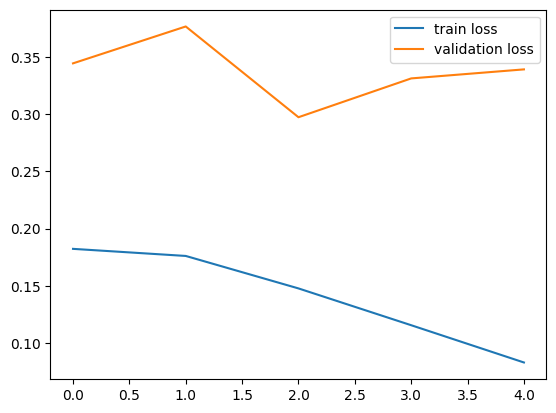

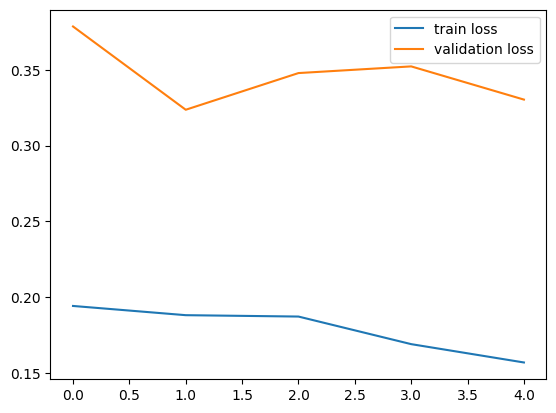

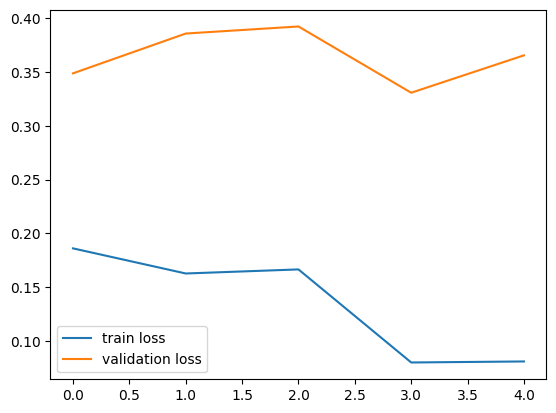

In [102]:
for i in range(3):
  plt.plot(history[i]["history"]["train_loss"],label="train")
  plt.plot(history[i]["history"]["val_loss"],label="val")
  plt.legend(["train loss","validation loss"])
  plt.show()

In [103]:
def predict(model,data_loader):
  model.eval()
  predicteds = []
  actual = []
  with torch.no_grad():
      for i,(x, y) in enumerate(data_loader):
          if i >= len(data_loader):
                  break
          x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
          y = y[:,0].unsqueeze(-1)
          x = x.permute(0, 3, 1, 2)

          outputs = model(x)

          predicted = np.array(outputs.cpu().numpy()>=0.5).astype(int)
          actual.extend(y)
          predicteds.extend(predicted)

      return actual,predicteds

In [104]:
data = []
for folder in os.listdir(test_path):
  for file in os.listdir(os.path.join(test_path,folder)):
    data.append([os.path.join(test_path,folder,file),folder])

np.random.shuffle(data)
data = data[:500]
len(data)

500

In [105]:
test_datafram = pd.DataFrame(data,columns=["path","label"])

test_loader = test_generator.flow_from_dataframe(
 test_datafram ,
  x_col="path",
  y_col="label",
  target_size = (250,250),
  batch_size=128
  )


Found 500 validated image filenames belonging to 2 classes.


In [106]:
for t in range(3):
  actual,p = predict(history[t]['model'],test_loader)
  for i in range(len(actual)):
      actual[i] = actual[i].cpu().numpy()
  actual= np.array(actual)
  print(classification_report(actual,p))

              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70       254
         1.0       0.71      0.50      0.59       246

    accuracy                           0.65       500
   macro avg       0.67      0.65      0.65       500
weighted avg       0.67      0.65      0.65       500

              precision    recall  f1-score   support

         0.0       0.70      0.31      0.43       269
         1.0       0.51      0.85      0.64       231

    accuracy                           0.56       500
   macro avg       0.61      0.58      0.53       500
weighted avg       0.62      0.56      0.53       500

              precision    recall  f1-score   support

         0.0       0.62      0.43      0.51       243
         1.0       0.58      0.75      0.66       257

    accuracy                           0.60       500
   macro avg       0.60      0.59      0.58       500
weighted avg       0.60      0.60      0.59       500

